This script illustrates how to select samples based on the predictions of a pretrained 2D U-Net. There are multiple ways to do this: 
- Random: this is the baseline approach that is usually used, i.e. annotate randomly selected regions in the image and finetune the segmentation. 
- Maximum entropy: generally the best selection criterion. Make sure to check the samples however as this criterion does not take sample diversity into account. 

We will start by loading in the required modules and configuring the environment. 

In [1]:
# configure environment
import sys
sys.path.append('/home/jorisro/research/neuralnets')  # adjust this if necessary! This should point to the neuralnets repository

# dependencies
import numpy as np
import yaml
import os
import torch
import matplotlib.pyplot as plt

from neuralnets.networks.unet import UNet2D
from neuralnets.util.io import print_frm, read_volume
from neuralnets.util.tools import set_seed, parse_params
from neuralnets.util.validation import segment

We need to initialize the model, so it's advised to use the same parameter configuration file as with the training notebook. 

In [2]:
param_config_file = 'train.yaml'  # adjust this path/file if necessary! 
with open(param_config_file) as file:
    params = parse_params(yaml.load(file, Loader=yaml.FullLoader))

We will now load the dataset that we want to test. 

In [3]:
# input shape as a 3-tuple (e.g. (1, 256, 256))
input_shape = (1, *(params['input_size']))  

# load the volume that is considered for annotation
print_frm('Loading data')
data_path = '/home/jorisro/research/data/EM/EPFL/volumedata'
data = read_volume(data_path, type='pngseq', progress=True, start=0, stop=100)

[2022-05-24 13:11:59.937076] Loading data


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 41.13it/s]


As an illustration, we can show a randomly selected sample of this dataset. 

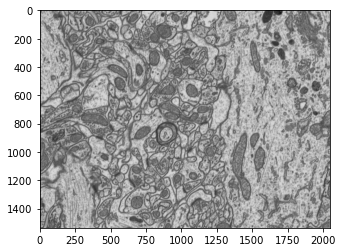

In [4]:
x = data[np.random.randint(len(data))]
plt.imshow(x, cmap='gray')
plt.show()

Now that we have data, it's time to intialize the model! 

In [5]:
print_frm('Building the network')
net = UNet2D(in_channels=params['in_channels'], feature_maps=params['fm'], levels=params['levels'],
             dropout_enc=params['dropout'], dropout_dec=params['dropout'], norm=params['norm'],
             activation=params['activation'], coi=params['coi'], loss_fn=params['loss'])

# load the parameters of the model
ckpt_file = 'model.ckpt'
net.load_state_dict(torch.load(ckpt_file)['state_dict'])

[2022-05-24 13:12:02.696774] Building the network


<All keys matched successfully>

We can now apply the model on the complete volume. 

In [6]:
y = segment(data, net, params['input_size'], in_channels=params['in_channels'], track_progress=True)

Progress z-axis:   0%|          | 0/100 [00:00<?, ?it/s]

Now that we have the model predictions, we can select a batch of samples! 

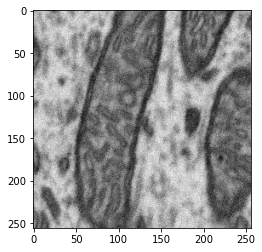

In [7]:
def select_samples(x, y=None, n_s=10, n_c=100, sz=(1, 256, 256), method='random'):
    """
    Select samples of a dataset (optionally according to network predictions) that can be used for annotation. 

    :param x: input data (shape [Z, Y, X])
    :param optional y: predictions (shape [C, Z, Y, X], required if method=='entropy') 
    :param optional n_s: number of samples to be selected
    :param optional n_c: number of samples considered in the volume
    :param optional sz: size of the selected samples
    :param optional method: sample selection strategy (either 'random' or 'entropy')
    :return: a tuple (x_, coos) containing the selected samples x (shape [n_s, *sz]) and their corresponding coordinates coos (shape [n_s, 3])
    """
    
    def _select_samples_random(x, n_s=10, sz=(1, 256, 256)):
        """
        Randomly select samples of a dataset that can be used for annotation. 

        :param x: input data (shape [Z, Y, X])
        :param optional n_s: number of samples to be selected
        :param optional sz: size of the selected samples
        :return: coordinates (shape [n_s, 3]) of the selected samples
        """
        
        x_sz = np.asarray(x.shape)
        s_sz = np.asarray(sz)
        
        # generate random coordinates
        coos = np.zeros((n_s, 3), dtype=int)
        for d in range(3):
            high = x_sz[d] - s_sz[d]
            coos[:, d] = np.random.randint(high, size=n_s)
        
        return coos
    
    def _select_samples_entropy(x, y, n_s=10, n_c=100, sz=(1, 256, 256)):
        """
        Select maximum entropy samples of a dataset (according to model predictions) that can be used for annotation. 

        :param x: input data (shape [Z, Y, X])
        :param optional y: predictions (shape [C, Z, Y, X]) 
        :param optional n_s: number of samples to be selected
        :param optional n_c: number of samples considered in the volume
        :param optional sz: size of the selected samples
        :return: a tuple (x_, coos) containing the selected samples x (shape [n_s, *sz]) and their corresponding coordinates coos (shape [n_s, 3])
        """
        
        x_sz = np.asarray(x.shape)
        s_sz = np.asarray(sz)
        r_sz = x_sz - s_sz
        zs, ys, xs = sz
        
        # loop over all considered samples and compute entropy
        x_ = np.zeros((n_c, *sz))
        entropies = np.zeros((n_c))
        coos = np.zeros((n_c, 3), dtype=int)
        for i in range(n_c):
            coos[i] = [np.random.randint(r_sz[d]) for d in range(3)]
            zs_, ys_, xs_ = coos[i]
            y_ = y[:, zs_:zs_+zs, ys_:ys_+ys, xs_:xs_+xs]
            entropies[i] = - np.mean(np.sum(y_ * np.log(y_), axis=0))
            x_[i] = x[zs_:zs_+zs, ys_:ys_+ys, xs_:xs_+xs]
        
        # sort the computed entropies and select the n_s highest ones
        i_max = np.argsort(entropies)[-n_s:]
        coos = coos[i_max]
        x_ = x_[i_max]
        
        return x_, coos
    
    def _extract_samples(x, coos, sz=(1, 256, 256)):
        """
        Extract samples of a dataset based on a set of coordinates

        :param x: input data (shape [Z, Y, X])
        :param optional coos: coordinates that should be sampled (shape [n_s, 3])
        :param optional sz: size of the selected samples
        :return: selected samples x (shape [n_s, *sz])
        """
        
        zs, ys, xs = sz
        
        x_ = np.zeros((len(coos), *sz))
        for i in range(len(coos)):
            zs_, ys_, xs_ = coos[i]
            x_[i] = x[zs_:zs_+zs, ys_:ys_+ys, xs_:xs_+xs]
        
        return x_
    
    
    # select the samples and obtain their corresponding coordinates
    if method=='entropy':
        x_, coos = _select_samples_entropy(x, y, n_s=n_s, n_c=n_c, sz=sz)
    else:
        coos = _select_samples_random(x, n_s=n_s, sz=sz)
        # extract the samples based on the coordinates
        x_ = _extract_samples(x, coos)
    
    
    return x_, coos


# select samples
n_s = 10            # amount of samples to select
n_c = 100           # amount of samples that are considered in the volume
sz = (1, 256, 256)  # size of the samples to be selected
method = 'entropy'  # type of sampling (random or entropy)
x_, coos = select_samples(data, y=y, n_s=n_s, n_c=n_c, sz=sz, method=method)

# show a sample that was selected
plt.imshow(x_[np.random.randint(n_s), 0], cmap='gray')
plt.show()

The `x_` volume can now be annotated and used for finetuning the segmentation model. 